<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1691]:
!pip install hmmlearn
!pip install yfinance

In [1692]:
from hmmlearn import hmm
import yfinance as yf

In [1693]:
df = yf.download('itc.ns',start='2015-01-01',end='2021-10-14')#period='max'
#median = df.loc[df['Close']<10, 'Close'].median()
#df["Close"] = np.where(df["Close"] <10, df.Close.mean(),df['Close'])


[*********************100%***********************]  1 of 1 completed


In [1694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [1695]:
df.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-13,242.550003,250.899994,240.149994,249.199997,249.199997,50139555


In [1696]:
returns = np.log(df['Close']).diff(3)

In [1697]:
returns.dropna(inplace=True)

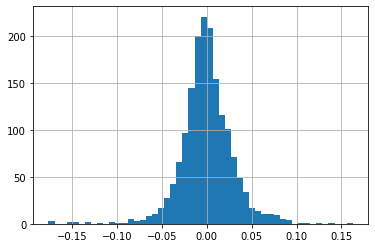

In [1698]:
returns.hist(bins=50);

In [1699]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [1700]:
#retu = np.column_stack([returns]) =====> returns.to_numpy().reshape(-1, 1)


In [1701]:
X = returns.to_numpy().reshape(-1, 1)
print(X.shape)
model.fit(X)

(1669, 1)


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [1702]:
Z = model.predict(X)

In [1703]:
Z

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

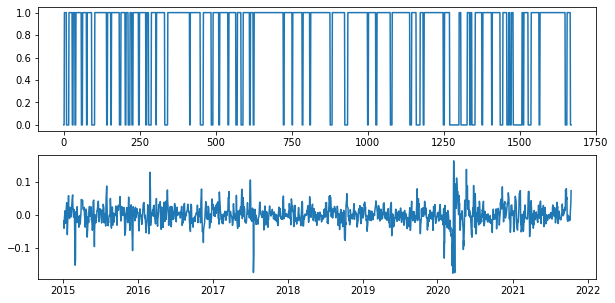

In [1704]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

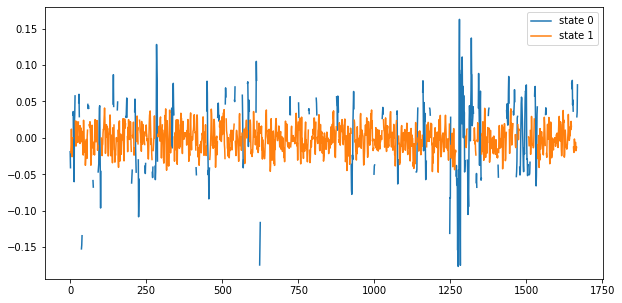

In [1705]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [1706]:
# transition matrix
model.transmat_

array([[0.69945818, 0.30054182],
       [0.12499029, 0.87500971]])

In [1707]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [1708]:
returns[Z==0].mean()

0.005913114892251054

In [1709]:
returns[Z==1].mean()

-0.0015106567297532114

In [1710]:
zero=(returns[Z==0]).mean()

In [1711]:
one=(returns[Z==1]).mean()

In [1712]:
print(f'zero {zero}')
print(f'one {one}')

zero 0.005913114892251054
one -0.0015106567297532114


In [1713]:
# run inference again
Z = model.predict(X)
# first create arrays with nan
returns_vol = np.empty(len(Z))
returns_vol[:] = np.nan
if one>0:
  returns_vol[Z==0]=1
  returns_vol[Z==1]=0
elif one<0:
  returns_vol[Z==0]=0
  returns_vol[Z==1]=1
ret=returns.reset_index()
zi= pd.concat([ret.Date,ret.Close,pd.Series(Z),pd.Series(returns_vol)],axis=1)
zi=zi.set_index('Date')
zi.columns=['pct_chg','pred','Volatility']



In [1714]:
#print(abcd)

In [1715]:
zi.to_csv('daa.csv')

In [1716]:
def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.Volatility.iloc[i]==1 and df.Volatility.iloc[i-1]==0 :
      reg1.append(i)
    elif df.Volatility.iloc[i]==0 and df.Volatility.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [1717]:
sell,buy=plot_buy_sell_signal(zi)

In [1723]:
sell =[i+3*2 for i in sell]
buy = [i+3*2 for i in buy]
buy[-1]=1671

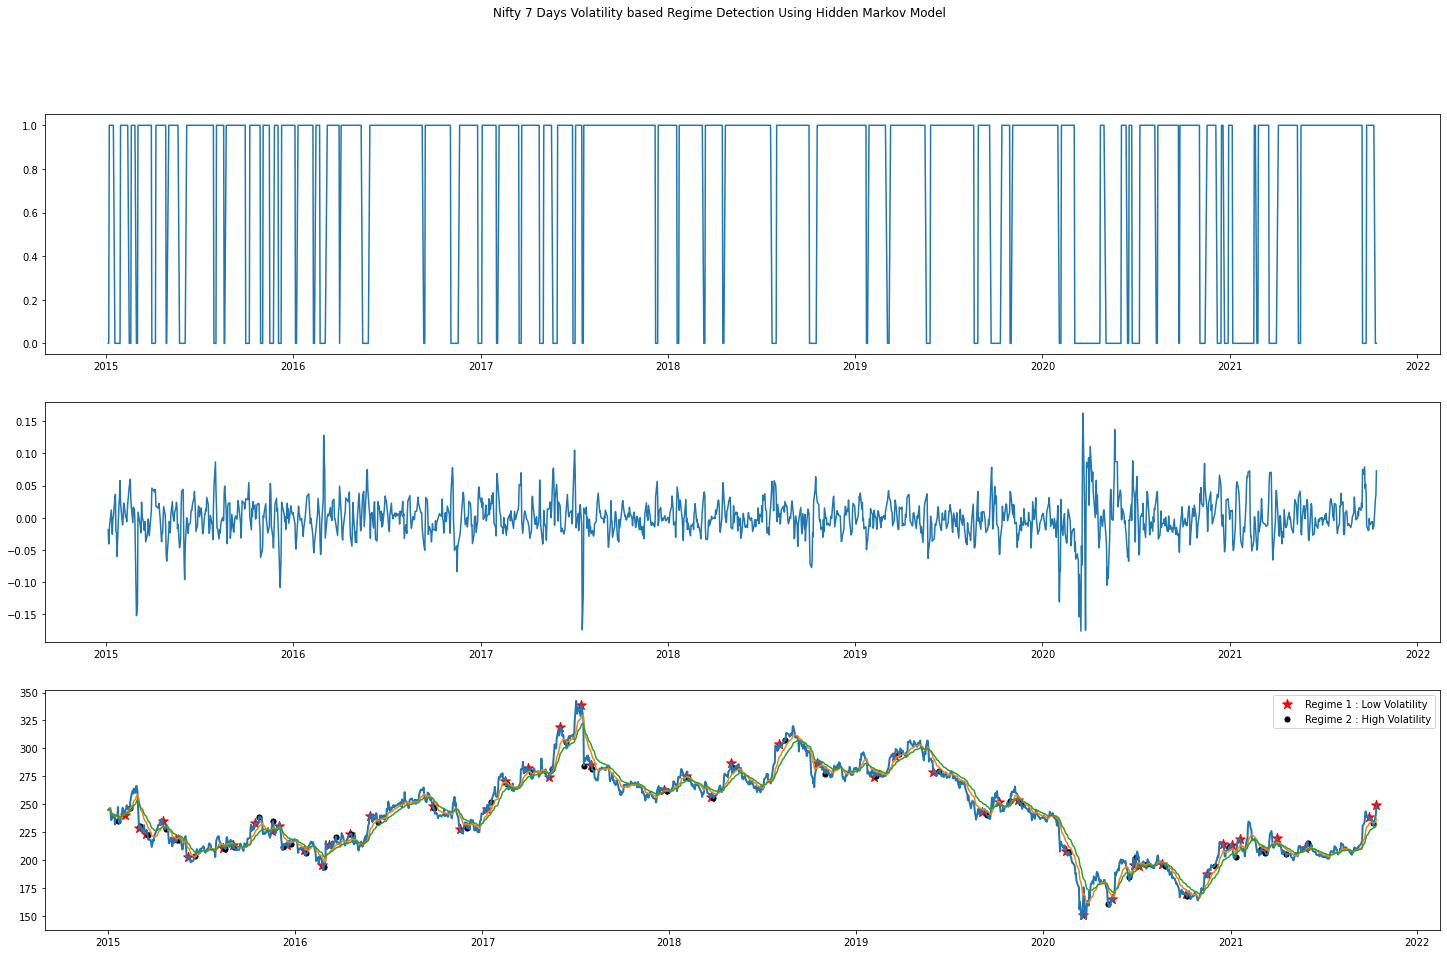

In [1724]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi.Volatility[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['Close'][:],linewidth=2)
plt.plot(df["Close"].ewm(span=13).mean())
plt.plot(df["Close"].ewm(span=26).mean())
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

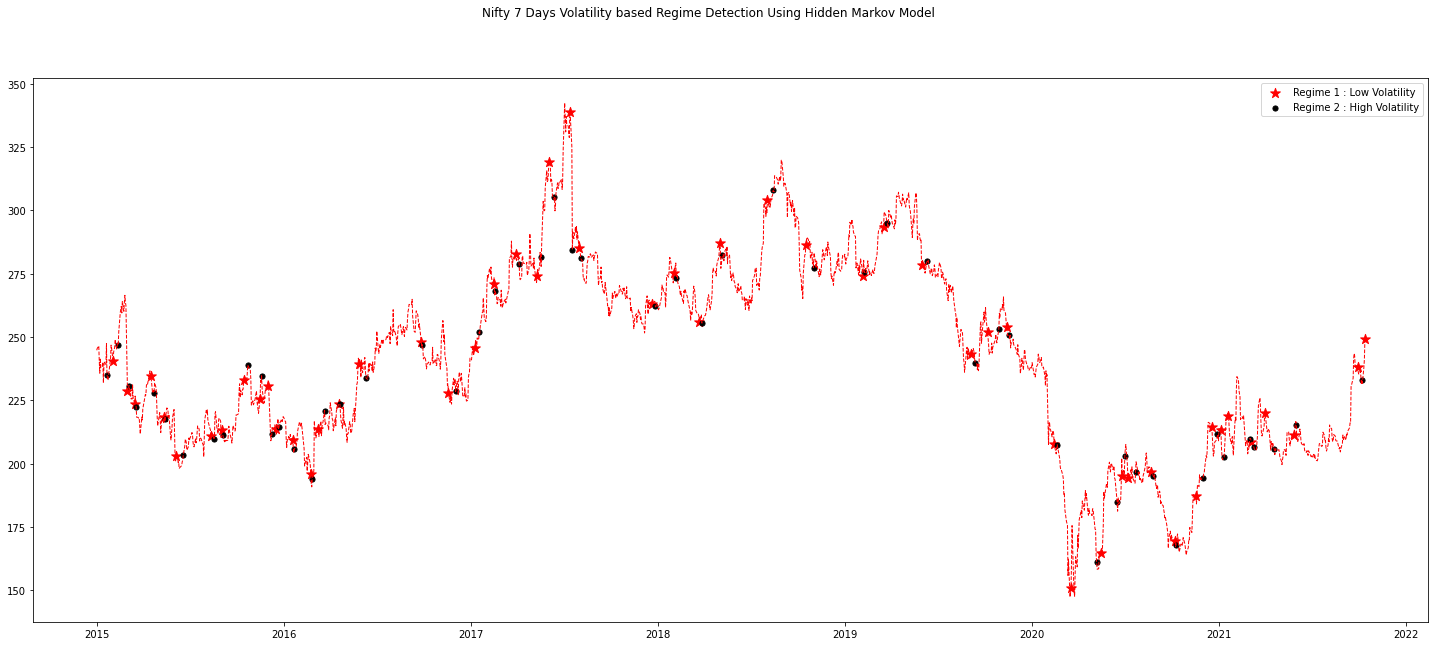

In [1725]:
fig, ax = plt.subplots(figsize=(25,10),sharex=True)
plt.plot(df['Close'][:],'r--',linewidth=1)
#plt.plot(df["Close"].ewm(span=13).mean(),color='g')
#plt.plot(df["Close"].ewm(span=26).mean(),color='r')
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

In [1720]:
buy[-1],sell[-1]

(1672, 1661)

In [ ]:
lst=[buy[-1],sell[-1]]
max(lst)

In [1721]:
df.shape

(1672, 6)

In [ ]:
'''
if High_vol=0:
  df.loc[0,'Regime']='High Volatility'
if High_vol=1: 
  df.loc[0,'Regime']='High Volatility' 
'''  

In [ ]:
df=pd.concat([df,zi.Volatility],axis=1)

In [ ]:
df.Volatility.value_counts()

In [ ]:
if df['Volatility'][-1]!=(df['Volatility'][-2] or df['Volatility'][-3] or df['Volatility'][-4]):
  print(f'Change in Regime ---> Present Regime {df["Volatility"][-1]}')
else:
  print(f'No Change in Regime We are in The Regime of : {df["Volatility"][-1]}') 


In [ ]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))



# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [ ]:
df.tail(10)

In [ ]:
len(df)

In [ ]:
(df.Close[-2]-df.Close[-5])/df.Close[-5]

In [ ]:
df.tail(10)

In [ ]:
	Open	High	Low	Close	Adj Close	Volume	Volatility not div by 3
Date							
2021-09-09	211.050003	213.899994	210.550003	212.649994	212.649994	19051252	1.0
2021-09-13	213.350006	215.149994	211.800003	214.149994	214.149994	16043896	1.0
2021-09-14	214.899994	217.250000	214.199997	216.100006	216.100006	19621849	1.0
2021-09-15	217.100006	217.199997	215.300003	216.000000	216.000000	20248758	1.0
2021-09-16	216.949997	233.649994	216.300003	230.750000	230.750000	149238901	0.0
2021-09-17	233.000000	237.300003	229.100006	231.149994	231.149994	79501805	0.0
2021-09-20	231.000000	239.350006	230.250000	233.750000	233.750000	70390969	0.0
2021-09-21	234.949997	242.449997	231.699997	241.500000	241.500000	56671832	0.0
2021-09-22	243.500000	245.800003	240.699997	243.500000	243.500000	52621868	0.0
2021-09-23	245.000000	245.600006	241.699997	242.500000	242.500000	21791090	0.0

In [ ]:
Date		div by 3					
2021-09-13	213.350006	215.149994	211.800003	214.149994	214.149994	16043896	1.0
2021-09-14	214.899994	217.250000	214.199997	216.100006	216.100006	19621849	1.0
2021-09-15	217.100006	217.199997	215.300003	216.000000	216.000000	20248758	1.0
2021-09-16	216.949997	233.649994	216.300003	230.750000	230.750000	149238901	0.0
2021-09-17	233.000000	237.300003	229.100006	231.149994	231.149994	79501805	0.0
2021-09-20	231.000000	239.350006	230.250000	233.750000	233.750000	70390969	0.0
2021-09-21	234.949997	242.449997	231.699997	241.500000	241.500000	56671832	0.0
2021-09-22	243.500000	245.800003	240.699997	243.500000	243.500000	52621868	0.0
2021-09-23	245.000000	245.600006	241.699997	242.500000	242.500000	21791090	0.0
2021-09-24	244.000000	244.000000	237.699997	238.449997	238.449997	24823291	1.0